# Object detection demo

The code for this demo is from https://medium.com/@siromermer/pipeline-for-training-custom-faster-rcnn-object-detection-models-with-pytorch-d506d2423343, https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html, https://docs.pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html


## Step 1: Initialise GPU if available

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

'''
If there is a GPU, it will display 'cuda'. Otherwise, it will show 'cpu'
'''

cuda


"\nIf there is a GPU, it will display 'cuda'. Otherwise, it will show 'cpu'\n"

## Step 2: Define dataset class

Here we suppose the data is stored in COCO format. 

In [2]:
class AquariumDataset(Dataset): # in COCO format
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(obj['category_id'])
            
        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)

        boxes = boxes.detach().clone().reshape(-1, 4)

        # Package everything into a target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply transforms if any were passed
        if self.transforms:
            image = self.transforms(image)

        return image, target

## Step 3: Load training and validation data

In [3]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Returns a simple transform that converts a PIL image to a PyTorch tensor
def get_transform():
    return ToTensor()

# Load training dataset with transform applied
train_dataset = AquariumDataset(
    image_dir='aquarium/train',
    annotation_path='aquarium/train/_annotations.coco.json',
    transforms=get_transform()
)

# Load validation dataset with same transform
val_dataset = AquariumDataset(
    image_dir='aquarium/valid',
    annotation_path='aquarium/valid/_annotations.coco.json',
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Step 4: Get the object category names (in the variable 'class_names'). Each category may be under a supercategory.

In [4]:
cats = train_dataset.coco.loadCats(train_dataset.coco.getCatIds())
cat_names = [cat['name'] for cat in cats]
print('category names', cat_names)

# Get the number of classes in the dataset (including background)
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background class

print('number of classes', num_classes)

cat_details = train_dataset.coco.loadCats(train_dataset.coco.getCatIds())[:len(cat_names)]
print('category details', cat_details)

category names ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
number of classes 9
category details [{'id': 0, 'name': 'creatures', 'supercategory': 'none'}, {'id': 1, 'name': 'fish', 'supercategory': 'creatures'}, {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'}, {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'}, {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'}, {'id': 5, 'name': 'shark', 'supercategory': 'creatures'}, {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'}, {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}]


## Step 5: Load a pre-trained model (e.g., 'FasterRCNN_ResNet50_FPN_Weights', i.e., Faster RCNN with ResNet50 backbone) for the Faster RCNN

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Get the number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the specified device (GPU or CPU)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Step 6: Set learning parameters

In [6]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set the number of epochs for training
num_epochs = 5

## Step 7: Train the Faster RCNN

Make sure that you have the following files in your working directory
- utils.py
- transforms.py
- coco_eval.py
- engine.py
- coco_utils.py

These files can be found at https://github.com/pytorch/vision/tree/main/references/detection

In [7]:
from engine import train_one_epoch, evaluate

# Loop through each epoch
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')


Epoch 1/5


c:\Users\micha\OneDrive\Desktop\manual backup laptop\deakin stuff\deakintrimester3\SIT789 - Applications of Computer Vision and Speech Processing\task5.1\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/112]  eta: 0:01:43  lr: 0.000050  loss: 2.9984 (2.9984)  loss_classifier: 2.4920 (2.4920)  loss_box_reg: 0.3616 (0.3616)  loss_objectness: 0.1295 (0.1295)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 0.9211  data: 0.0740  max mem: 4258
Epoch: [0]  [ 25/112]  eta: 0:00:45  lr: 0.001175  loss: 1.3524 (1.7634)  loss_classifier: 0.6922 (1.1247)  loss_box_reg: 0.4211 (0.4591)  loss_objectness: 0.1151 (0.1457)  loss_rpn_box_reg: 0.0308 (0.0339)  time: 0.5004  data: 0.0502  max mem: 5849
Epoch: [0]  [ 50/112]  eta: 0:00:44  lr: 0.002300  loss: 0.9978 (1.4439)  loss_classifier: 0.4548 (0.8150)  loss_box_reg: 0.4619 (0.4766)  loss_objectness: 0.0499 (0.1194)  loss_rpn_box_reg: 0.0232 (0.0328)  time: 0.9495  data: 0.0513  max mem: 7118
Epoch: [0]  [ 75/112]  eta: 0:00:28  lr: 0.003425  loss: 0.8292 (1.2572)  loss_classifier: 0.3972 (0.6810)  loss_box_reg: 0.3716 (0.4523)  loss_objectness: 0.0295 (0.0949)  loss_rpn_box_reg: 0.0135 (0.0290)  time: 0.8885  data: 0.0511  max mem: 7118


## Step 8: Test the Faster RCNN with a single image

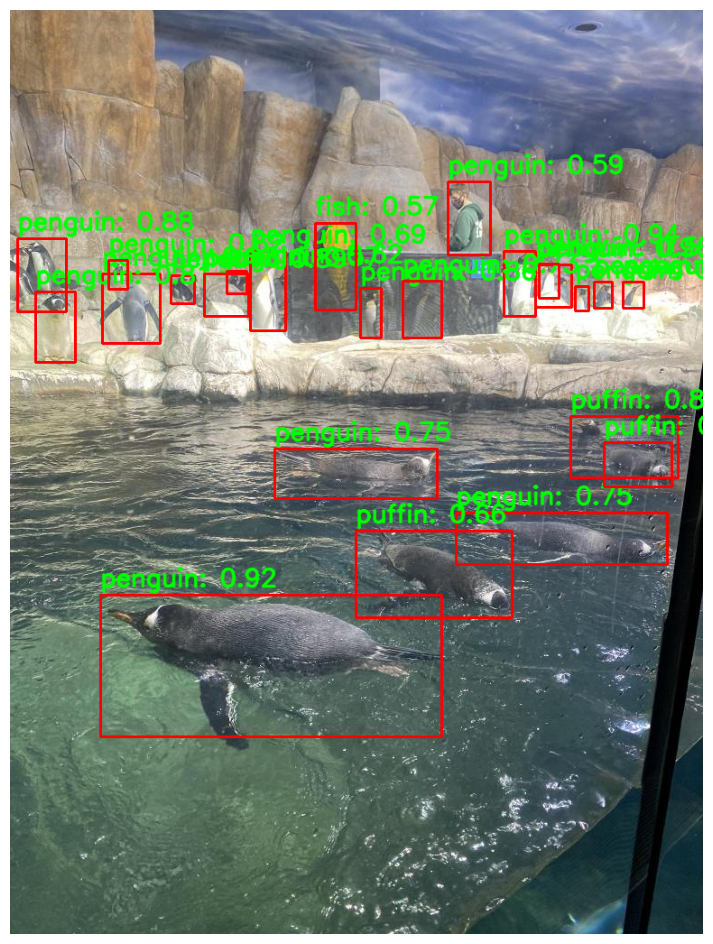

In [9]:
from torchvision import models, transforms

# Load the same model architecture with correct number of classes
model = models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)

model.load_state_dict(torch.load('model_epoch_5.pth'))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = 'aquarium/test/IMG_3164_jpeg_jpg.rf.06637eee0b72df791aa729807ca45c4d.jpg' # CHANGE this to your image path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Parse predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Threshold
threshold = 0.55
for i in range(len(boxes)):
    if scores[i] > threshold:    
        box = boxes[i].cpu().numpy().astype(int)
        label = cat_names[labels[i]]
        score = scores[i].item()

        # draw label and score
        text = f'{label}: {score:.2f}'
        cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 255, 0), 2, cv2.LINE_AA)

        # Draw rectangle and label
        cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

# Convert BGR to RGB for correct display with matplotlib
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show image with larger figure size
plt.figure(figsize=(16, 12))  # Increase size as needed
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Step 9: Evaluate the Faster RCNN in the test set

In [11]:
from engine import evaluate
from coco_eval import CocoEvaluator

# Load test dataset with same transform
test_dataset = AquariumDataset(
    image_dir='aquarium/test',
    annotation_path='aquarium/test/_annotations.coco.json',
    transforms=get_transform()
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

evaluator = evaluate(model.cuda(), test_loader, device=device)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.2960 (0.2960)  evaluator_time: 0.0010 (0.0010)  time: 0.3110  data: 0.0110  max mem: 7119
Test:  [62/63]  eta: 0:00:00  model_time: 0.0500 (0.0541)  evaluator_time: 0.0020 (0.0034)  time: 0.0621  data: 0.0095  max mem: 7119
Test: Total time: 0:00:04 (0.0682 s / it)
Averaged stats: model_time: 0.0500 (0.0541)  evaluator_time: 0.0020 (0.0034)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ I

In [13]:
from torchvision.models.detection.faster_rcnn import FasterRCNN_MobileNet_V3_Large_320_FPN_Weights 
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn( weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to C:\Users\micha/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


100%|██████████| 74.2M/74.2M [00:11<00:00, 6.60MB/s]


In [14]:
# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN

# Get the number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the specified device (GPU or CPU)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [15]:
# Get parameters that require gradients (the model's trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Set the number of epochs for training
num_epochs = 5

In [16]:
from engine import train_one_epoch, evaluate

# Loop through each epoch
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f'model_mobilenet_epoch_{epoch + 1}.pth')


Epoch 1/5


c:\Users\micha\OneDrive\Desktop\manual backup laptop\deakin stuff\deakintrimester3\SIT789 - Applications of Computer Vision and Speech Processing\task5.1\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/112]  eta: 0:00:50  lr: 0.000050  loss: 2.9400 (2.9400)  loss_classifier: 2.2504 (2.2504)  loss_box_reg: 0.5004 (0.5004)  loss_objectness: 0.1301 (0.1301)  loss_rpn_box_reg: 0.0592 (0.0592)  time: 0.4475  data: 0.0670  max mem: 7119
Epoch: [0]  [ 25/112]  eta: 0:00:15  lr: 0.001175  loss: 1.2566 (1.8465)  loss_classifier: 0.6525 (1.2999)  loss_box_reg: 0.3191 (0.3916)  loss_objectness: 0.0859 (0.1195)  loss_rpn_box_reg: 0.0335 (0.0355)  time: 0.1626  data: 0.0685  max mem: 7119
Epoch: [0]  [ 50/112]  eta: 0:00:11  lr: 0.002300  loss: 0.7030 (1.3273)  loss_classifier: 0.3676 (0.8557)  loss_box_reg: 0.2592 (0.3257)  loss_objectness: 0.0598 (0.1068)  loss_rpn_box_reg: 0.0262 (0.0391)  time: 0.1842  data: 0.0705  max mem: 7119
Epoch: [0]  [ 75/112]  eta: 0:00:06  lr: 0.003425  loss: 0.8306 (1.1685)  loss_classifier: 0.3655 (0.6992)  loss_box_reg: 0.3183 (0.3241)  loss_objectness: 0.0852 (0.1020)  loss_rpn_box_reg: 0.0330 (0.0432)  time: 0.1499  data: 0.0645  max mem: 7119


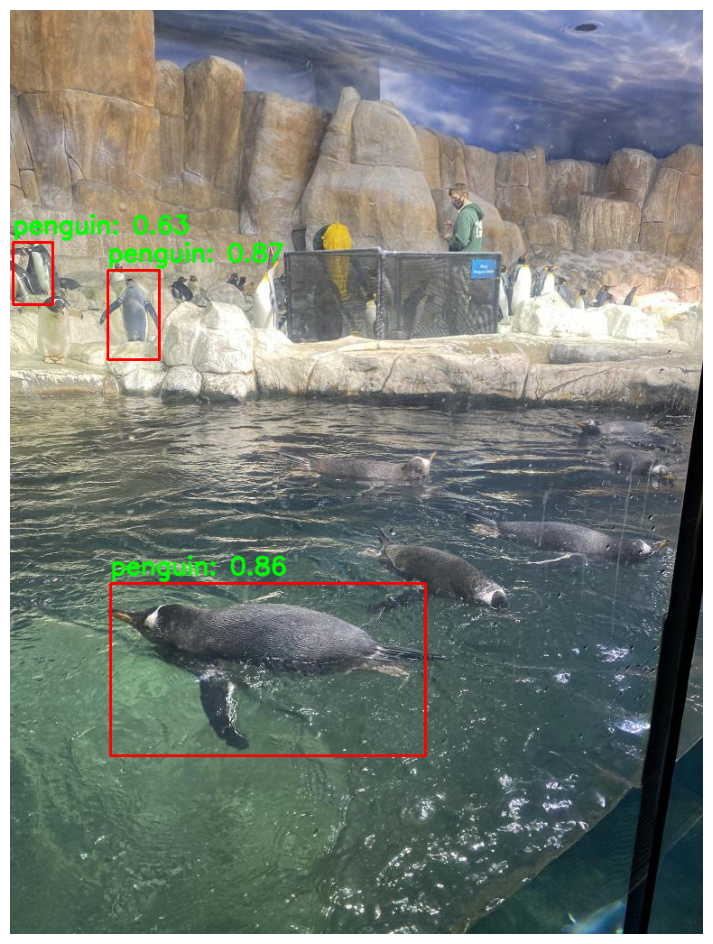

In [23]:
from torchvision import models, transforms

# Load the same model architecture with correct number of classes
model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None, num_classes=num_classes)

model.load_state_dict(torch.load('model_mobilenet_epoch_5.pth'))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = 'aquarium/test/IMG_3164_jpeg_jpg.rf.06637eee0b72df791aa729807ca45c4d.jpg' # CHANGE this to your image path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Parse predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Threshold
threshold = 0.55
for i in range(len(boxes)):
    if scores[i] > threshold:    
        box = boxes[i].cpu().numpy().astype(int)
        label = cat_names[labels[i]]
        score = scores[i].item()

        # draw label and score
        text = f'{label}: {score:.2f}'
        cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 255, 0), 2, cv2.LINE_AA)

        # Draw rectangle and label
        cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

# Convert BGR to RGB for correct display with matplotlib
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show image with larger figure size
plt.figure(figsize=(16, 12))  # Increase size as needed
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [24]:
from engine import evaluate
from coco_eval import CocoEvaluator

# Load test dataset with same transform
test_dataset = AquariumDataset(
    image_dir='aquarium/test',
    annotation_path='aquarium/test/_annotations.coco.json',
    transforms=get_transform()
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

evaluator = evaluate(model.cuda(), test_loader, device=device)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
creating index...
index created!
Test:  [ 0/63]  eta: 0:00:19  model_time: 0.3000 (0.3000)  evaluator_time: 0.0010 (0.0010)  time: 0.3150  data: 0.0110  max mem: 7119
Test:  [62/63]  eta: 0:00:00  model_time: 0.0150 (0.0204)  evaluator_time: 0.0010 (0.0025)  time: 0.0292  data: 0.0108  max mem: 7119
Test: Total time: 0:00:02 (0.0346 s / it)
Averaged stats: model_time: 0.0150 (0.0204)  evaluator_time: 0.0010 (0.0025)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ I